# When Do Neural Networks Outperform Kernel Methods?

## Imports

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from tqdm import tqdm 

import importlib
import model
importlib.reload(model)
from model import NTKRR
from model import RFKRR
from model import NN

2025-02-01 17:57:47.068824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-01 17:57:47.077121: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-01 17:57:47.178499: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-01 17:57:47.304430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738429067.404896  476934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738429067.43

## Pipeline pour entrainer les différents modèles

In [2]:
class Pipeline:
    """
    Pipeline pour l'entraînement et l'évaluation de plusieurs modèles de classification 
    sur les datasets utilisés.

    Ce pipeline permet d'exécuter différents modèles :
    - Réseau de neurones dense (MLP)
    - Réseau de neurones convolutionnel (CNN)
    - Modèle basé sur le Neural Tangent Kernel Ridge Regression (NTKRR)
    - Modèle basé sur les Random Fourier Features Ridge Regression (RFKRR)
    
    Il inclut également des fonctions pour afficher une matrice de confusion et des prédictions visuelles.
    """

    def __init__(self, X_train, X_test, y_train, y_test, classes_to_keep=None):
        """
        Initialise le pipeline en stockant les données d'entraînement et de test.

        Args:
            X_train (numpy.ndarray): Données d'entraînement (images).
            X_test (numpy.ndarray): Données de test (images).
            y_train (numpy.ndarray): Labels des données d'entraînement.
            y_test (numpy.ndarray): Labels des données de test.
            classes_to_keep (list, optionnel): Liste des classes à conserver. Défaut : `[0, 1, ..., 9]`.
        """
        if classes_to_keep is None:
            classes_to_keep = list(range(10))

        self.image_size = X_train[0].shape
        self.X_train_subset = X_train
        self.y_train_subset = y_train
        self.X_test_subset = X_test
        self.y_test_subset = y_test
        self.classes_to_keep = classes_to_keep
        self.y_pred = None
        self.method = None

        self.y_train_one_hot = to_categorical(self.y_train_subset, num_classes=len(self.classes_to_keep))
        self.y_test_one_hot = to_categorical(self.y_test_subset, num_classes=len(self.classes_to_keep))

    def run_nn(self, learning_rate=0.001, epochs=15, batch_size=64):
        """
        Exécute un réseau de neurones dense (MLP).

        Args:
            learning_rate (float, optionnel): Taux d'apprentissage. Défaut à 0.001.
            epochs (int, optionnel): Nombre d'époques d'entraînement. Défaut à 15.
            batch_size (int, optionnel): Taille du batch. Défaut à 64.
        """
        print("Exécution NN")

        num_classes = len(self.classes_to_keep)
      
        X_train_tensor = self.X_train_subset.reshape(-1, 28, 28, 1)
        X_train_tensor = X_train_tensor / 255.0
        X_test_tensor = self.X_test_subset.reshape(-1, 28, 28, 1)  
        X_test_tensor = X_test_tensor / 255.0

        if len(self.y_train_subset.shape) == 1:
            self.y_train_subset = to_categorical(self.y_train_subset, num_classes=num_classes)
            self.y_test_subset = to_categorical(self.y_test_subset, num_classes=num_classes)

        model = NN(num_classes=num_classes, learning_rate=learning_rate, conv=False)
        model.fit(X_train_tensor, self.y_train_subset, epochs=epochs, batch_size=batch_size, validation_data=(X_test_tensor, self.y_test_subset))

        self.y_pred = np.argmax(model.predict(X_test_tensor), axis=1)

    def run_cnn(self, learning_rate=0.001, epochs=15, batch_size=64):
        """
        Exécute un réseau de neurones convolutionnel (CNN).

        Args:
            learning_rate (float, optionnel): Taux d'apprentissage. Défaut à 0.001.
            epochs (int, optionnel): Nombre d'époques d'entraînement. Défaut à 15.
            batch_size (int, optionnel): Taille du batch. Défaut à 64.
        """
        print("Exécution CNN")

        num_classes = len(self.classes_to_keep)

        X_train_tensor = self.X_train_subset.reshape(-1, 28, 28, 1)
        X_test_tensor = self.X_test_subset.reshape(-1, 28, 28, 1)

        if len(self.y_train_subset.shape) == 1:
            self.y_train_subset = to_categorical(self.y_train_subset, num_classes=num_classes)
            self.y_test_subset = to_categorical(self.y_test_subset, num_classes=num_classes)

        model = NN(num_classes=num_classes, learning_rate=learning_rate, conv=True)
        model.fit(X_train_tensor, self.y_train_subset, epochs=epochs, batch_size=batch_size, validation_data=(X_test_tensor, self.y_test_subset))

        self.y_pred = np.argmax(model.predict(X_test_tensor), axis=1)

    def run_nt_krr(self, nt_dim=4096, alpha=0.1):
        """
        Exécute un modèle basé sur le Neural Tangent Kernel Ridge Regression (NTKRR).

        Args:
            nt_dim (int, optionnel): Dimension cachée pour l'approximation du NTK. Défaut à 4096 comme spécifié dans le papier.
            alpha (float, optionnel): Facteur de régularisation pour Ridge Regression. Défaut à 0.1.
        """
        print("Exécution NTKRR")

        output_dim = len(self.classes_to_keep)

        model = NTKRR(hidden_dim=nt_dim, output_dim=output_dim, image_size=self.image_size)

        kernel_train = model.compute_ntk(self.X_train_subset, self.X_train_subset)
        kernel_test = model.compute_ntk(self.X_test_subset, self.X_train_subset)

        ridge = RidgeClassifier(alpha=alpha, fit_intercept=False)
        ridge.fit(kernel_train, self.y_train_subset)

        self.y_pred = ridge.predict(kernel_test)

    def run_rf_krr(self, rf_dim=321126, alpha=0.01, sigma=0.01):
        """
        Exécute un modèle basé sur les Random Fourier Features Ridge Regression (RFKRR).

        Args:
            rf_dim (int, optionnel): Dimension cachée pour les Fourier Features. Défaut à 321126 comme spécifié dans le papier.
            alpha (float, optionnel): Facteur de régularisation. Défaut à 0.01.
            sigma (float, optionnel): Paramètre de lissage pour RFF. Défaut à 0.01.
        """
        print("Exécution RFKRR")
       
        rfkrr = RFKRR(rff_dim=rf_dim, alpha=alpha, sigma=sigma)
 
        X_train_flat = self.X_train_subset.reshape(len(self.X_train_subset), -1)
        X_test_flat = self.X_test_subset.reshape(len(self.X_test_subset), -1)

        rfkrr.fit(X_train_flat, self.y_train_subset)

        self.y_pred = rfkrr.predict(X_test_flat)
        
    def plot_confusion_matrix(self):
        """
        Affiche la matrice de confusion des prédictions.
        """
        y_true = np.argmax(self.y_test_subset, axis=1)
        y_pred = self.y_pred
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.classes_to_keep, yticklabels=self.classes_to_keep)
        plt.xlabel('Prédictions')
        plt.ylabel('Vérité terrain')
        plt.title(f'Matrice de Confusion - {self.method}')
        plt.show()

    def plot_predictions(self, num_images=10):
        """
        Affiche `num_images` exemples de l'ensemble de test avec leurs labels prédits.

        Args:
            num_images (int, optionnel): Nombre d'images à afficher. Défaut à 10.
        """
        X_test = self.X_test_subset
        y_true = self.y_test_subset
        y_pred = self.y_pred
        
        fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
        for i in range(num_images):
            ax = axes[i]
            img = X_test[i].reshape(self.image_size)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Vérité : {int(y_true[i])}\nPrédiction : {y_pred[i]}")
        plt.tight_layout()
        plt.show()



## Modèle des covariables "spiked"

train set noising


Generating dataset: 100%|██████████| 60000/60000 [00:03<00:00, 19846.57it/s]


test set noising


100%|██████████| 10000/10000 [00:00<00:00, 18606.13it/s]


train set noising


Generating dataset: 100%|██████████| 60000/60000 [00:03<00:00, 18375.59it/s]


test set noising


100%|██████████| 10000/10000 [00:00<00:00, 19245.66it/s]


train set noising


Generating dataset: 100%|██████████| 60000/60000 [00:03<00:00, 19682.05it/s]


test set noising


100%|██████████| 10000/10000 [00:00<00:00, 19680.06it/s]


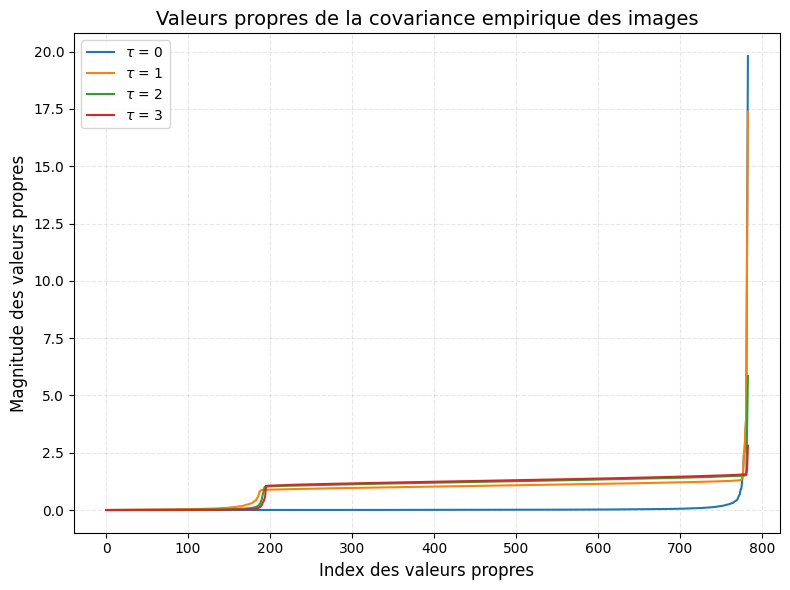

In [4]:
import SpikedDataset
importlib.reload(SpikedDataset)
from SpikedDataset import SpikedDataset

subset_size = (60000, 10000)
generator = SpikedDataset(dataset="FMNIST", subset_size=subset_size)
generator.plot_eigenvalues()

Frequency decomposition: 100%|██████████| 60000/60000 [00:01<00:00, 51508.53it/s]


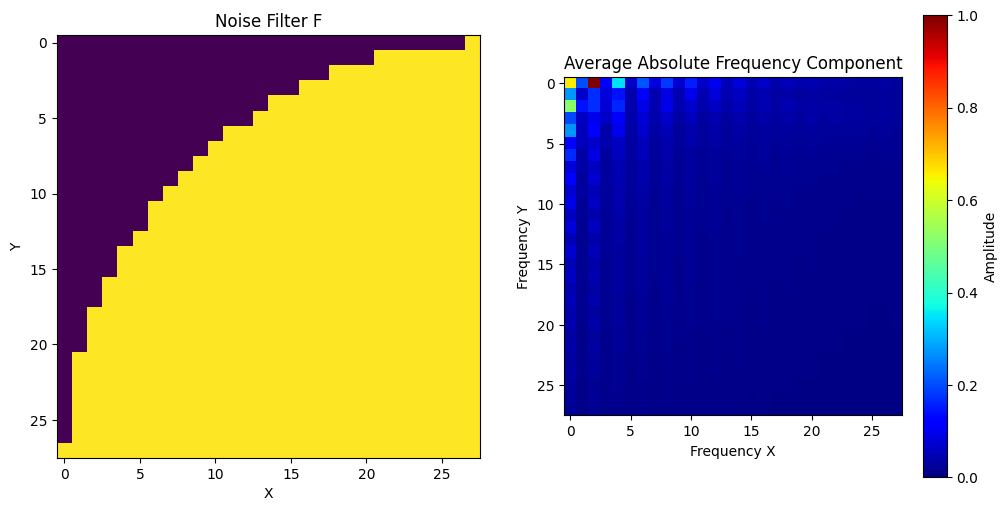

In [ ]:
generator = SpikedDataset(dataset='FMNIST', subset_size=subset_size)
F = generator.plot_frequency_repartition()

# Expérience 1 : Influence du bruit hautes fréquences

On limite l'expérience à un dataset train de 25000 images car les NTKRR prennent énormément de ressources CPU/GPU pour calculer les noyaux. Nos ordinateurs n'étant pas capables de calculer de telles dimensions de noyaux on restreint l'expérience, induisant nécessairement de moins bons résultats que ceux présentés dans le papier.

L'expérience est réalisée sur des intensités de bruit allant de tau=0 jusqu'à tau=4.

## Dataset Fashion-MNIST

In [5]:
import SpikedDataset
importlib.reload(SpikedDataset)
from SpikedDataset import *

accuracies = {
    "ntkrr":[],
    "rfkrr":[],
    "nn":[],
    "cnn":[]
}


subset_size=(25000, 5000)
tau_values = np.linspace(0, 3, num=5) 
classes_to_keep = list(range(0,10))

for tau in tqdm(tau_values):
    print(f"{'#'*30} Level noise : {tau} {'#'*30}")

    generator = SpikedDataset(dataset='FMNIST', subset_size=subset_size)
    X_train_processed,X_test_processed,y_train_processed,y_test_processed = generator.generate_spiked_dataset(classes_to_keep=classes_to_keep, tau=tau)
    pipeline = Pipeline(X_train=X_train_processed,X_test=X_test_processed,y_train=y_train_processed,y_test=y_test_processed,classes_to_keep=classes_to_keep)

    pipeline.run_nt_krr(nt_dim=256, alpha=0.01)
    accuracies["ntkrr"].append(accuracy_score(pipeline.y_test_subset, pipeline.y_pred))
    print(f'NTKRR accuracie {accuracies["ntkrr"][-1]}')

    pipeline.run_rf_krr(rf_dim=4096, alpha=0.01, sigma=0.01)
    accuracies["rfkrr"].append(accuracy_score(pipeline.y_test_subset, pipeline.y_pred))
    print(f'RFKRR accuracie {accuracies["rfkrr"][-1]}')

    pipeline.run_nn(learning_rate = 0.001, epochs=30, batch_size=256)
    accuracies["nn"].append(accuracy_score(np.argmax(pipeline.y_test_subset, axis=1), pipeline.y_pred))
    print(f'NN accuracie {accuracies["nn"][-1]}')

    pipeline.run_cnn(learning_rate = 0.001, epochs=15, batch_size=256)
    accuracies["cnn"].append(accuracy_score(np.argmax(pipeline.y_test_subset, axis=1), pipeline.y_pred))
    print(f'CNN accuracie {accuracies["cnn"][-1]}')

  0%|          | 0/5 [00:00<?, ?it/s]

############################## Level noise : 0.0 ##############################
Exécution NTKRR


/home/marius/envs/main_venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.99789e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


NTKRR accuracie 0.8354
Exécution RFKRR
RFKRR accuracie 0.8186
Exécution NN


2025-02-01 18:00:32.197937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-01 18:00:32.198549: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: marius-PC
2025-02-01 18:00:32.198554: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: marius-PC
2025-02-01 18:00:32.198982: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2025-02-01 18:00:32.198997: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-02-01 18:00:32.198999: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3690 - loss: 1.7883 - val_accuracy: 0.6828 - val_loss: 0.8367
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6868 - loss: 0.8266 - val_accuracy: 0.7452 - val_loss: 0.6803
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7439 - loss: 0.6893 - val_accuracy: 0.7832 - val_loss: 0.5971
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7756 - loss: 0.5924 - val_accuracy: 0.7974 - val_loss: 0.5620
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7968 - loss: 0.5440 - val_accuracy: 0.8090 - val_loss: 0.5217
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8208 - loss: 0.4981 - val_accuracy: 0.8186 - val_loss: 0.5026
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8273 - loss: 0.4741 - val_accuracy: 0.8216 - val_loss: 0.4918
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8348 - loss: 0.4588 - val_accuracy: 0.8230 - val_loss:

 20%|██        | 1/5 [02:46<11:04, 166.17s/it]

CNN accuracie 0.9016
############################## Level noise : 1.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 19722.41it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 19452.24it/s]


Exécution NTKRR


/home/marius/envs/main_venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.96012e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


NTKRR accuracie 0.7988
Exécution RFKRR
RFKRR accuracie 0.7922
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3174 - loss: 1.8669 - val_accuracy: 0.6488 - val_loss: 0.8900
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6619 - loss: 0.8640 - val_accuracy: 0.7384 - val_loss: 0.7155
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7375 - loss: 0.6888 - val_accuracy: 0.7510 - val_loss: 0.6490
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7765 - loss: 0.6058 - val_accuracy: 0.7688 - val_loss: 0.6186
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7932 - loss: 0.5631 - val_accuracy: 0.7774 - val_loss: 0.5980
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8097 - loss: 0.5166 - val_accuracy: 0.7746 - val_loss: 0.5995
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8231 - loss: 0.4830 - val_accuracy: 0.7874 - val_loss: 0.5792
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6m

 40%|████      | 2/5 [05:19<07:56, 158.71s/it]

CNN accuracie 0.8484
############################## Level noise : 2.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 17899.60it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 18113.86it/s]


Exécution NTKRR
NTKRR accuracie 0.7986
Exécution RFKRR
RFKRR accuracie 0.7828
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2332 - loss: 2.0389 - val_accuracy: 0.5990 - val_loss: 1.0450
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5863 - loss: 1.0205 - val_accuracy: 0.6616 - val_loss: 0.8962
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6450 - loss: 0.8978 - val_accuracy: 0.7074 - val_loss: 0.7909
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7152 - loss: 0.7418 - val_accuracy: 0.7276 - val_loss: 0.7261
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7401 - loss: 0.6746 - val_accuracy: 0.7366 - val_loss: 0.7029
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7641 - loss: 0.6096 - val_accuracy: 0.7414 - val_loss: 0.6866
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7898 - loss: 0.5537 - val_accuracy: 0.7480 - val_loss: 0.6709
Epoch 8/30
98/98 ━━━━━━━━━━

 60%|██████    | 3/5 [07:55<05:14, 157.28s/it]

CNN accuracie 0.8432
############################## Level noise : 3.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 19291.73it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 19453.20it/s]


Exécution NTKRR
NTKRR accuracie 0.8048
Exécution RFKRR
RFKRR accuracie 0.773
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1641 - loss: 2.1725 - val_accuracy: 0.5232 - val_loss: 1.1896
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5197 - loss: 1.1519 - val_accuracy: 0.6070 - val_loss: 0.9722
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6067 - loss: 0.9769 - val_accuracy: 0.6376 - val_loss: 0.9193
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6303 - loss: 0.9098 - val_accuracy: 0.6518 - val_loss: 0.8802
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6646 - loss: 0.8365 - val_accuracy: 0.6800 - val_loss: 0.8264
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7044 - loss: 0.7502 - val_accuracy: 0.6924 - val_loss: 0.7785
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7436 - loss: 0.6730 - val_accuracy: 0.7084 - val_loss: 0.7638
Epoch 8/30
98/98 ━━━━━━━━━━━

 80%|████████  | 4/5 [10:30<02:36, 156.43s/it]

CNN accuracie 0.8174
############################## Level noise : 4.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 19742.83it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 19923.07it/s]


Exécution NTKRR
NTKRR accuracie 0.8004
Exécution RFKRR
RFKRR accuracie 0.7502
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1450 - loss: 2.2374 - val_accuracy: 0.4426 - val_loss: 1.4380
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4694 - loss: 1.2960 - val_accuracy: 0.5714 - val_loss: 1.0606
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5677 - loss: 1.0593 - val_accuracy: 0.6044 - val_loss: 0.9826
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6127 - loss: 0.9678 - val_accuracy: 0.6308 - val_loss: 0.9327
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6384 - loss: 0.8935 - val_accuracy: 0.6192 - val_loss: 0.9426
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6668 - loss: 0.8392 - val_accuracy: 0.6726 - val_loss: 0.8635
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7048 - loss: 0.7549 - val_accuracy: 0.6678 - val_loss: 0.8601
Epoch 8/30
98/98 ━━━━━━━━━━

100%|██████████| 5/5 [13:11<00:00, 158.25s/it]

CNN accuracie 0.8226


## Affichage des résultats

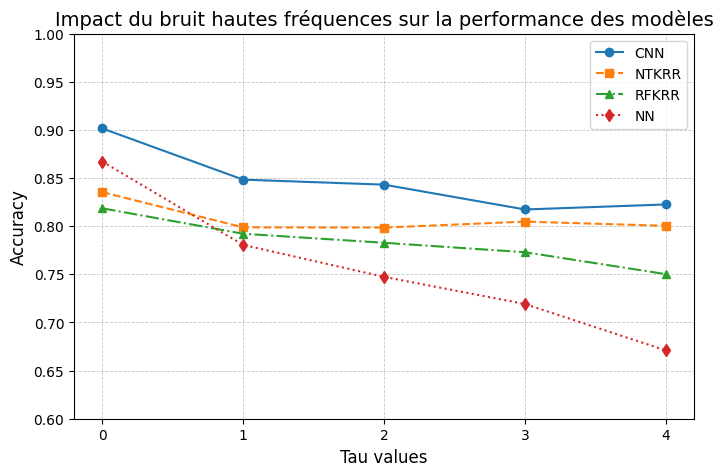

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  

plt.plot(tau_values, accuracies["cnn"], marker='o', linestyle='-', label="CNN")
plt.plot(tau_values, accuracies["ntkrr"], marker='s', linestyle='--', label="NTKRR")
plt.plot(tau_values, accuracies["rfkrr"], marker='^', linestyle='-.', label="RFKRR")
plt.plot(tau_values, accuracies["nn"], marker='d', linestyle=':', label="NN")

plt.xlabel("Tau values", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Impact du bruit hautes fréquences sur la performance des modèles", fontsize=14)
plt.legend(fontsize=10, loc="best")
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.ylim(0.6, 1) 
plt.xticks(tau_values)  
plt.show()


Etonnament les résultats de l'influence du bruit sur les NN (Neural Networks) ne sont pas conformes à ceux présentés dans le papier. Le bruit hautes fréquences fait décroitre assez rapidement l'accuracy des NN, contrairement aux méthodes à noyaux qui semblent être robuste à phénomène. 
Plusieurs raisons peuvent expliquer de telles différences, tout d'abord nous avons restreint l'expérience à moins de la moitié du dataset ce qui impacte fortement les résultats. De plus les hyperparamètres utilisés peuvent influencer grandement les résultats, l'expérience n'est peut-être tout simplement pas reproductible sans la description exacte des hyperparamètres utilisés dans le papier.

## Dataset MNIST

In [8]:

accuracies = {
    "ntkrr":[],
    "rfkrr":[],
    "nn":[],
    "cnn":[]
}
from SpikedDataset import SpikedDataset

subset_size=(25000, 5000)
tau_values = np.linspace(0, 4, num=5) 
classes_to_keep = list(range(0,10))

for tau in tqdm(tau_values):
    print(f"{'#'*30} Level noise : {tau} {'#'*30}")

    generator = SpikedDataset(dataset='MNIST', subset_size=subset_size)
    X_train_processed,X_test_processed,y_train_processed,y_test_processed = generator.generate_spiked_dataset(classes_to_keep=classes_to_keep, tau=tau)
    pipeline = Pipeline(X_train=X_train_processed,X_test=X_test_processed,y_train=y_train_processed,y_test=y_test_processed,classes_to_keep=classes_to_keep)

    pipeline.run_nt_krr(nt_dim=256, alpha=0.01)
    accuracies["ntkrr"].append(accuracy_score(pipeline.y_test_subset, pipeline.y_pred))
    print(f'NTKRR accuracie {accuracies["ntkrr"][-1]}')

    pipeline.run_rf_krr(rf_dim=4096, alpha=0.01, sigma=0.01)
    accuracies["rfkrr"].append(accuracy_score(pipeline.y_test_subset, pipeline.y_pred))
    print(f'RFKRR accuracie {accuracies["rfkrr"][-1]}')

    pipeline.run_nn(learning_rate = 0.001, epochs=30, batch_size=256)
    accuracies["nn"].append(accuracy_score(np.argmax(pipeline.y_test_subset, axis=1), pipeline.y_pred))
    print(f'NN accuracie {accuracies["nn"][-1]}')

    pipeline.run_cnn(learning_rate = 0.001, epochs=15, batch_size=256)
    accuracies["cnn"].append(accuracy_score(np.argmax(pipeline.y_test_subset, axis=1), pipeline.y_pred))
    print(f'CNN accuracie {accuracies["cnn"][-1]}')

  0%|          | 0/5 [00:00<?, ?it/s]

############################## Level noise : 0.0 ##############################
Exécution NTKRR
NTKRR accuracie 0.9094
Exécution RFKRR
RFKRR accuracie 0.884
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3872 - loss: 1.9256 - val_accuracy: 0.7966 - val_loss: 0.6607
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7903 - loss: 0.6429 - val_accuracy: 0.8718 - val_loss: 0.4253
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8650 - loss: 0.4338 - val_accuracy: 0.8996 - val_loss: 0.3369
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8893 - loss: 0.3597 - val_accuracy: 0.9110 - val_loss: 0.3113
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9045 - loss: 0.3177 - val_accuracy: 0.9196 - val_loss: 0.2607
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9165 - loss: 0.2745 - val_accuracy: 0.9288 - val_loss: 0.2332
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9242 

 20%|██        | 1/5 [03:46<15:07, 226.97s/it]

CNN accuracie 0.9894
############################## Level noise : 1.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 12749.00it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 12550.16it/s]


Exécution NTKRR
NTKRR accuracie 0.8562
Exécution RFKRR
RFKRR accuracie 0.8542
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2526 - loss: 2.0408 - val_accuracy: 0.7374 - val_loss: 0.7828
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7372 - loss: 0.7611 - val_accuracy: 0.8468 - val_loss: 0.4953
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8405 - loss: 0.5028 - val_accuracy: 0.8680 - val_loss: 0.4114
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8742 - loss: 0.4006 - val_accuracy: 0.8716 - val_loss: 0.3889
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8940 - loss: 0.3407 - val_accuracy: 0.8864 - val_loss: 0.3469
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9075 - loss: 0.3013 - val_accuracy: 0.8938 - val_loss: 0.3332
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9291 - loss: 0.2412 - val_accuracy: 0.8976 - val_loss: 0.3091
Epoch 8/30
98/98 ━━━━━━━━

 40%|████      | 2/5 [07:03<10:27, 209.13s/it]

CNN accuracie 0.9858
############################## Level noise : 2.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 12766.72it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 12584.11it/s]


Exécution NTKRR
NTKRR accuracie 0.8542
Exécution RFKRR
RFKRR accuracie 0.8508
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1562 - loss: 2.2250 - val_accuracy: 0.5716 - val_loss: 1.2453
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5862 - loss: 1.1298 - val_accuracy: 0.7304 - val_loss: 0.7999
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7179 - loss: 0.8093 - val_accuracy: 0.7774 - val_loss: 0.6611
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7793 - loss: 0.6466 - val_accuracy: 0.8220 - val_loss: 0.5647
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8266 - loss: 0.5288 - val_accuracy: 0.8400 - val_loss: 0.5058
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8629 - loss: 0.4342 - val_accuracy: 0.8538 - val_loss: 0.4638
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8884 - loss: 0.3576 - val_accuracy: 0.8674 - val_loss: 0.4311
Epoch 8/30
98/98 ━━━

 60%|██████    | 3/5 [10:42<07:07, 213.54s/it]

CNN accuracie 0.9702
############################## Level noise : 3.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 12524.93it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 12994.17it/s]


Exécution NTKRR
NTKRR accuracie 0.8564
Exécution RFKRR
RFKRR accuracie 0.8496
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1188 - loss: 2.2922 - val_accuracy: 0.4030 - val_loss: 1.8011
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4075 - loss: 1.5896 - val_accuracy: 0.5944 - val_loss: 1.0973
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6109 - loss: 1.0623 - val_accuracy: 0.6942 - val_loss: 0.8536
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7004 - loss: 0.8469 - val_accuracy: 0.7316 - val_loss: 0.7510
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7497 - loss: 0.7248 - val_accuracy: 0.7792 - val_loss: 0.6492
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7931 - loss: 0.6064 - val_accuracy: 0.7926 - val_loss: 0.6117
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8307 - loss: 0.5110 - val_accuracy: 0.7916 - val_loss: 0.5974
Epoch 8/30
98/98 ━━━━━━━

 80%|████████  | 4/5 [14:05<03:29, 209.29s/it]

CNN accuracie 0.9666
############################## Level noise : 4.0 ##############################
train set noising


Generating dataset: 100%|██████████| 25000/25000 [00:01<00:00, 12836.04it/s]


test set noising


100%|██████████| 5000/5000 [00:00<00:00, 12894.27it/s]


Exécution NTKRR
NTKRR accuracie 0.86
Exécution RFKRR
RFKRR accuracie 0.8316
Exécution NN
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1119 - loss: 2.3008 - val_accuracy: 0.2286 - val_loss: 2.2275
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2700 - loss: 2.0085 - val_accuracy: 0.4804 - val_loss: 1.4023
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4911 - loss: 1.3521 - val_accuracy: 0.6424 - val_loss: 1.0216
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6257 - loss: 1.0187 - val_accuracy: 0.6870 - val_loss: 0.9093
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6961 - loss: 0.8480 - val_accuracy: 0.7370 - val_loss: 0.7775
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7637 - loss: 0.6809 - val_accuracy: 0.7632 - val_loss: 0.7186
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8074 - loss: 0.5572 - val_accuracy: 0.7676 - val_loss: 0.6920
Epoch 8/30
98/98 ━━━━━━━

100%|██████████| 5/5 [17:37<00:00, 211.56s/it]

CNN accuracie 0.9644


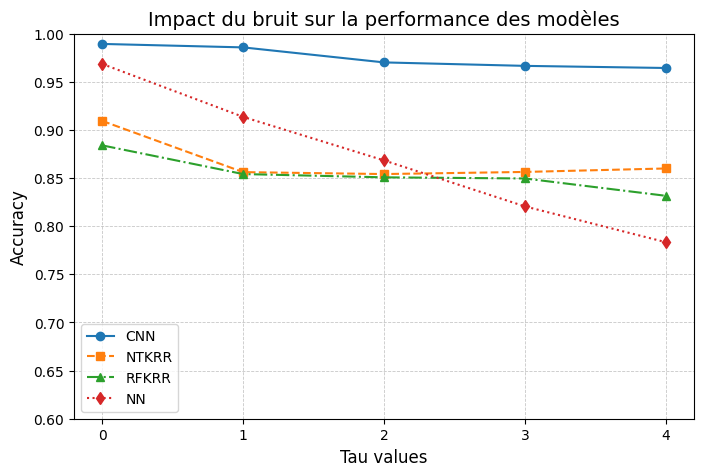

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  

plt.plot(tau_values, accuracies["cnn"], marker='o', linestyle='-', label="CNN")
plt.plot(tau_values, accuracies["ntkrr"], marker='s', linestyle='--', label="NTKRR")
plt.plot(tau_values, accuracies["rfkrr"], marker='^', linestyle='-.', label="RFKRR")
plt.plot(tau_values, accuracies["nn"], marker='d', linestyle=':', label="NN")

plt.xlabel("Tau values", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Impact du bruit sur la performance des modèles", fontsize=14)
plt.legend(fontsize=10, loc="best")
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.ylim(0.6, 1) 
plt.xticks(tau_values)  
plt.show()